# Metodo das Linhas

O método das linhas é um método semi-discreto para a resolução de EDP's que consiste em discretizar as variáveis espaciais e manter uma das varáveis contínua (usualmente o tempo), de modo a transformar a EDP em um sistema de EDO's que pode então ser
resolvido através dos métodos para a resolução de PVI's (como os métodos de Runge-Kutta). A abordagem utilizada para a discretização das variáveis espaciais usualmente é o método de diferenças finitas, por isso o método das linhas é muitas vezes chamado de método de diferenças finitas semi-discreto.

Como um exemplo, vamos ver como o método das linhas pode ser utilizado para resolver a equação do calor. A discussão teorica sobre o método das linhas pode ser encontrada no arquivo [em anexo](./assets/material_MOL.pdf). No exemplo resolvido no texto temos a segiunte equação do calor:

$$
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} - h' \alpha (T - T_a)
$$

onde $T$ é a temperatura, $t$ é o tempo, $x$ é a posição, $\alpha$ é a difusividade térmica, $h'$ é o coeficiente de transferência de calor por convecção e $T_a$ é a temperatura ambiente. 

<center>
<img src=./images/fig_mol.png>
</center>

As condições de contorno associadas a este problema são:

$$
T(t, 0) = T_{ext} \\
\frac{\partial T}{\partial x}|_{x=L} = 0
$$

onde $T_{ext}$ é a temperatura externa e $L$ é o comprimento da barra. As condições iniciais são:

$$
T(0, x) = T_{ini}
$$


Neste caso, será considerado um domínio somente com N = 6 pontos para ilustração:

<center>
<img src=./images/fig_mol1.png>
</center>


Neste caso, a discretização da EDP na direção x irá resultar um conjunto de valores $(T_1, T_2, T_3, T_4, T_5, T_6)$ que representam a temperatura nos pontos respectivos $(x_1, x_2, x_3, x_4, x_5, x_6)$. Neste caso, porém, estes valores Ti não são constantes, mas podem ser uma função do tempo.

Descritizando o dominio espacial, temos:

$$
\frac{\partial^2 T}{\partial x^2} = \frac{T_{i-1} - 2T_i + T_{i+1}}{\Delta x^2}
$$

subsituindo na equação do calor, temos:

$$
\frac{\partial T_i}{\partial t} = \alpha \frac{T_{i-1} - 2T_i + T_{i+1}}{\Delta x^2} - h' \alpha (T_i - T_a)
$$

Esta equação pode ser aplicada nos pontos i = 2, 3, 4, 5 para obter uma EDO para a temperatura em cada um destes pontos. Para resolver este sistema de EDO's, é preciso definir uma condição inicial para cada ponto. Como a temperatura inicial é considerada
constante e igual a Tini, basta associar este valor com a temperatura em cada ponto:

$$T_i(0) = T_{ini}$$

Para fechar o sistema de equações, é preciso ainda definir equações para $T_0$ e $T_6$, que são obtidas através da aplicação das condições de contorno. A condição $T(0, t) = T_{ext}$ resulta diretamente em:

$$T_1 = T_{ext}$$

Na extremidade $x = L$, a condição é de derivada nula. Neste caso pode-se aplicar um esquema de discretização para trás, de onde se obtém que $T_6 = T_5$. Com estas duas condições extras, o sistema de EDO's pode ser resolvido.

De forma resumida, as equações para os 6 pontos são

<center>
<img src=./images/fig_mol2.png>
</center>

Agora vamos implementar este problema no Python. Primeiro, vamos definir as constantes e as condições iniciais:

$$
\begin{align}
\alpha &= 0.01 \; cm^2/s\\
h' &= 0.1 \; cm^2\\
T_a &= 25 \; C\\
T_{ini} &= 25 \; C\\
T_{ext} &= 100 \; C\\
L &= 1 \; cm\\
\Delta x &= \frac{L}{N-1} \\
\Delta t &= 0.01 \\
\end{align}
$$



In [2]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.01
h = 0.1
T_a = 25.
T_ini = 25.
T_ext = 100.
L = 1.
N = 6
dx = L/(N - 1)
dt = 0.01

duration = 12000
t_eval = np.linspace(0, duration, 1000)

# Usando o metodo de Euler

Lembrando da implementação do método de Euler para resolver um PVI na forma 

$$
\frac{dy}{dt} = f(t,y) \\
$$

para fazer um passo $(y_i \rightarrow y_{i+1})$ temos:

In [15]:
def euler(func, ti, yi, h=1):
    return yi + func(ti, yi) * h

Agora para usar o método de Euler para resolver o problema de valor inicial, vamos usar a seguinte notação que é mais adequada quando temos um array e estamos no contexto de diferenças finitis:

In [3]:
alpha = 0.01
h = 0.1
T_a = 25.
T_ini = 25.
T_ext = 100.
L = 1.
N = 6
dx = L/(N - 1)
dt = 0.01

duration = int(120 / dt)
t_eval = np.linspace(0, duration, 1000)

In [ ]:


def _Euler(Tt, h = dt):
  
    Tt[0] = T_ext
    Tt[-1] = Tt[-2]
    n = len(Tt) - 1

    for i in range(1, n):
        Tt[i] = Tt[i] + h*(alpha * (Tt[i + 1] - 2 * Tt[i] + Tt[i - 1]) / dx ** 2 - h * alpha * (Tt[i] - T_a))
        
        #print(Tt)

    # enforce boundary conditions
    Tt[0] = T_ext
    Tt[-1] = Tt[-2]

    return Tt

In [5]:
T0 = np.ones(N) * T_ini

# boundary conditions
T0[0] = T_ext
T0[-1] = T0[-2]

Tts = [T0.copy()]

for _ in range(1, duration):
    Tts.append(_Euler(Tts[-1]).copy())

Tts = np.array(Tts)

In [23]:
Tts.shape

(12000, 6)

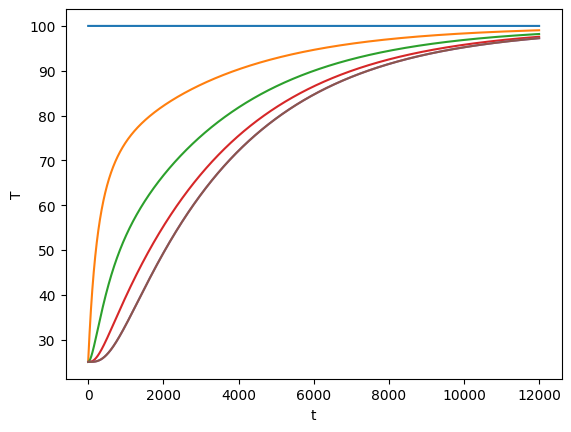

In [6]:
t = np.linspace(0, duration, duration)

plt.plot(t, Tts);
plt.xlabel('t')
plt.ylabel('T');    


# Py-PDE

$$
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} - h' \alpha (T - T_a)
$$

In [ ]:
from pde import CartesianGrid, DiffusionPDE, ScalarField
import numpy as np
import pde

In [ ]:
alpha = 0.01
h = 0.1
T_a = 25.0
T_ini = 25.0
T_ext = 100.0
L = 1.0
N = 60
dt = 0.01

duration = 120

T0 = np.ones(N) * T_ini # Condições iniciais
T0[0] = T_ext # Condições de contorno

  0%|          | 0/120.0 [00:00<?, ?it/s]

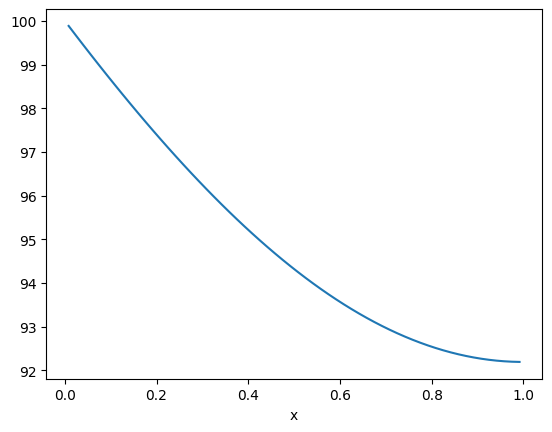

In [ ]:
grid = CartesianGrid([[0, L]], [N])  # generate grid

state = ScalarField(grid, data=T0)  # generate initial condition
bc_left = {"value": T_ext}  # boundary condition
bc_right = {"derivative": 0}  # boundary condition
bc = [bc_left, bc_right]  # combine boundary conditions
eq = pde.PDE({"T": "alpha*laplace(T) - h*alpha*(T - T_a)"}, 
             consts={"alpha": alpha, "h": h, "T_a": T_a},
             bc=bc)
storage = pde.MemoryStorage()
result = eq.solve(state, t_range=duration, dt=dt, tracker=["progress", storage.tracker(1)])
#result = eq.solve(state, t_range=100, dt=0.001, tracker=["plot", storage.tracker(1)])
result.plot();

In [ ]:
pde.movie(storage, filename='./outputs/MOL.mp4')

  0%|          | 0/121 [00:00<?, ?it/s]

# Scipy (Not working)

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

alpha = 0.01
h = 0.1
T_a = 25.0
T_ini = 25.0
T_ext = 100.0
L = 1.0
N = 10
dx = L / (N - 1)
dt = 0.01

duration = 120
t_eval = np.linspace(0, duration, 1000)

# Função que representa a EDP
def Eq(t, T):
    Tt = np.zeros_like(T)
    n = len(Tt) - 1
    Tt[0] = T_ext
    #Tt[-1] = Tt[-2]
    
    #Tt[1:-1] = alpha * (Tt[2:] - 2 * Tt[1:-1] + Tt[:-2]) / dx ** 2 - h * alpha * (Tt[1:-1] - T_a)
    for i in range(1, n):
        Tt[i] = alpha * (T[i + 1] - 2 * T[i] + T[i - 1]) / dx ** 2 - h * alpha * (T[i] - T_a)
        #alpha * (Tt[i + 1] - 2 * Tt[i] + Tt[i - 1]) / dx ** 2 - h * alpha * (Tt[i] - T_a)
    
    
    # Aplicação das condições de contorno
    Tt[0] = T_ext
    Tt[-1] = Tt[-2]
    print(t, Tt)
    
    return Tt

# Condições iniciais
T0 = np.ones(N) * T_ini
T0[0] = T_ext

print(T0)
print(Eq(0, T0))

# Resolver a EDP usando solve_ivp
res = solve_ivp(Eq, (0, duration), T0, t_eval=t_eval, method='RK45', max_step=0.01)


# Plot do resultado

plt.figure(figsize=(10, 6))
plt.plot(res.t, res.y.T)
plt.xlabel('Tempo')
plt.ylabel('T')
plt.title('Solução da EDP')
plt.grid(True)
plt.show()


In [33]:
res.y.shape

(10, 1000)

In [34]:
res.y

array([[  100.        ,   112.01201201,   124.02402402, ...,
        12075.97597598, 12087.98798799, 12100.        ],
       [   25.        ,    32.189396  ,    39.22494523, ...,
        11057.05039451, 11068.86123017, 11080.67236109],
       [   25.        ,    25.32982404,    26.23233235, ...,
        10173.13225177, 10184.75953227, 10196.38739325],
       ...,
       [   25.        ,    25.        ,    25.00000012, ...,
         7687.86383731,  7698.92444025,  7709.98658874],
       [   25.        ,    25.        ,    25.        , ...,
         7565.19404828,  7576.22456006,  7587.25667189],
       [   25.        ,    25.        ,    25.        , ...,
         7565.19404828,  7576.22456006,  7587.25667189]])